In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import time
import sklearn
import scipy

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [3]:
from Classification import model_fit, plot_confusion_matrix, model_fit2, plot_prob, get_precision_recall

In [4]:
heart = pd.read_csv('FinalHeart.csv')
heart.drop(['Unnamed: 0'],axis=1,inplace=True)

heartPCA = pd.read_csv('PCAData.csv')
heartPCA.drop(['Unnamed: 0'],axis=1, inplace=True)
heartPCA['num'] = heart.num

heartICA = pd.read_csv('ICAData.csv')
heartICA.drop(['Unnamed: 0'],axis=1, inplace=True)
heartICA['num'] = heart.num

heartFactor = pd.read_csv('FactorData.csv')
heartFactor.drop(['Unnamed: 0'],axis=1, inplace=True)
heartFactor['num'] = heart.num

In [5]:
X = heart.drop(['num'],axis=1).copy()
Y = heart.num.copy()
XPCA = heartPCA.drop(['num'],axis=1).copy()
YPCA = heartPCA.num.copy()
XICA = heartICA.drop(['num'],axis=1).copy()
YICA = heartICA.num.copy()
XFactor = heartFactor.drop(['num'],axis=1).copy()
YFactor = heartFactor.num.copy()

In [6]:
SC = StandardScaler()

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size= 0.33, stratify = Y)
X_train_scaled, X_test_Scaled, Y_train_scaled, Y_test_scaled = train_test_split(SC.fit_transform(X), Y, test_size= 0.33, stratify = Y)
X_train_PCA, X_test_PCA, Y_train_PCA, Y_test_PCA = train_test_split(XPCA, YPCA, test_size = 0.33, random_state=144, shuffle=True, stratify = Y)
X_train_ICA, X_test_ICA, Y_train_ICA, Y_test_ICA = train_test_split(XICA, YICA, test_size = 0.33, random_state=144, shuffle=True, stratify = Y)
X_train_F, X_test_F, Y_train_F, Y_test_F = train_test_split(XFactor, YFactor, test_size = 0.33, random_state=144, shuffle=True, stratify = Y)

In [8]:
dtc = DecisionTreeClassifier()
dtc.set_params( random_state = 144)
model_fit2(dtc, X_train, X_test, Y_train, Y_test)

DecisionTreeClassifier

Train score is :1.0
Test score is :0.538


In [9]:
dtc = DecisionTreeClassifier()
dtc.set_params(random_state = 144)
model_fit2(dtc, X_train_scaled, X_test_Scaled, Y_train_scaled, Y_test_scaled)

DecisionTreeClassifier

Train score is :1.0
Test score is :0.513


In [10]:
dtc = DecisionTreeClassifier()
model_fit2(dtc, X_train_PCA, X_test_PCA, Y_train_PCA, Y_test_PCA)

DecisionTreeClassifier

Train score is :1.0
Test score is :0.525


In [11]:
dtc = DecisionTreeClassifier()
model_fit2(dtc, X_train_ICA, X_test_ICA, Y_train_ICA, Y_test_ICA)

DecisionTreeClassifier

Train score is :1.0
Test score is :0.479


In [12]:
dtc = DecisionTreeClassifier()
model_fit2(dtc, X_train_F, X_test_F, Y_train_F, Y_test_F)

DecisionTreeClassifier

Train score is :1.0
Test score is :0.563


In [13]:
criterion      = ['gini','entropy','log_loss']
max_depth      = np.arange(1,80, 5)
max_features   = np.arange(1,14,2)
min_samples_split = np.arange(2,20,2)

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#dtc = DecisionTreeClassifier()
#dtc.set_params( random_state = 144)

#param_grid = {'criterion':criterion, 'max_depth':max_depth, 'max_features':max_features,
              #'min_samples_split':min_samples_split}

#dtc_grid = GridSearchCV(dtc, param_grid, cv = 3, return_train_score=True)
#%time dtc_grid.fit(X_train, Y_train)

In [ ]:
#dtc_df = pd.DataFrame(dtc_grid.cv_results_)
#dtc_df.shape

In [ ]:
#dtc_df.dropna(axis = 0, how = 'any', inplace=True)

In [ ]:
#dtc_df.shape

In [ ]:
#dtc_final_df = dtc_df.loc[:,['param_criterion','param_max_depth','param_max_features',
                            'param_min_samples_split','mean_train_score','mean_test_score']]

In [ ]:
#dtc_final_df['diff'] = abs(dtc_final_df['mean_train_score']-dtc_final_df['mean_test_score'])

In [ ]:
#dtc_final_df.to_csv('DecisionTree.csv')

In [ ]:
#print('Training score is :' + str(np.round(dtc_grid.best_estimator_.score(X_train, Y_train),2)))
#print('Testing  score is :' + str(np.round(dtc_grid.best_estimator_.score(X_test, Y_test),2)))

In [15]:
#final decision tree model
dtc = DecisionTreeClassifier()
dtc.set_params(criterion = 'entropy', max_depth = 3, max_features = 5, min_samples_split = 12, random_state = 144)
model_fit2(dtc, X_train, X_test, Y_train, Y_test)

DecisionTreeClassifier

Train score is :0.645
Test score is :0.63


In [21]:
#final decision tree model
dtc_scaled = DecisionTreeClassifier()
dtc_scaled.set_params(criterion = 'entropy', max_depth = 3, max_features = 10, min_samples_split = 12, random_state = 144,
                     min_impurity_decrease = 0.05)
model_fit2(dtc_scaled, X_train_scaled, X_test_Scaled, Y_train_scaled, Y_test_scaled)

DecisionTreeClassifier

Train score is :0.637
Test score is :0.63


In [28]:
dtc_PCA = DecisionTreeClassifier()
dtc_PCA.set_params(criterion = 'entropy', max_depth = 3, max_features = 10, min_samples_split = 12, random_state = 144,
                  min_impurity_decrease = 0.1)
model_fit2(dtc_PCA, X_train_PCA, X_test_PCA, Y_train_PCA, Y_test_PCA)

DecisionTreeClassifier

Train score is :0.62
Test score is :0.601


In [31]:
dtc_ICA = DecisionTreeClassifier()
dtc_ICA.set_params(criterion = 'entropy', min_weight_fraction_leaf = 0.08, random_state = 144, 
                  min_impurity_decrease = 0.07)
model_fit2(dtc_ICA, X_train_ICA, X_test_ICA, Y_train_ICA, Y_test_ICA)

DecisionTreeClassifier

Train score is :0.598
Test score is :0.605


In [32]:
dtc_F = DecisionTreeClassifier()
dtc_F.set_params(criterion = 'entropy', min_weight_fraction_leaf = 0.09, random_state = 144,
                min_impurity_decrease = 0.08)
model_fit2(dtc_F, X_train_F, X_test_F, Y_train_F, Y_test_F)

DecisionTreeClassifier

Train score is :0.587
Test score is :0.584


DecisionTreeClassifier


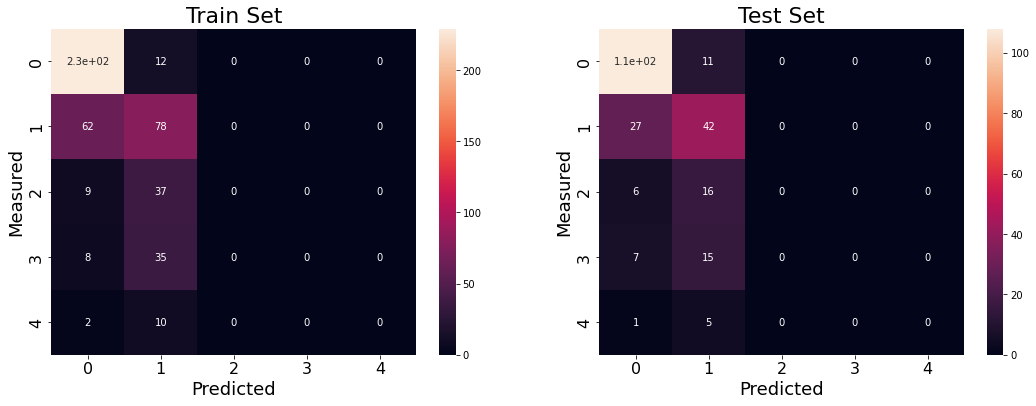

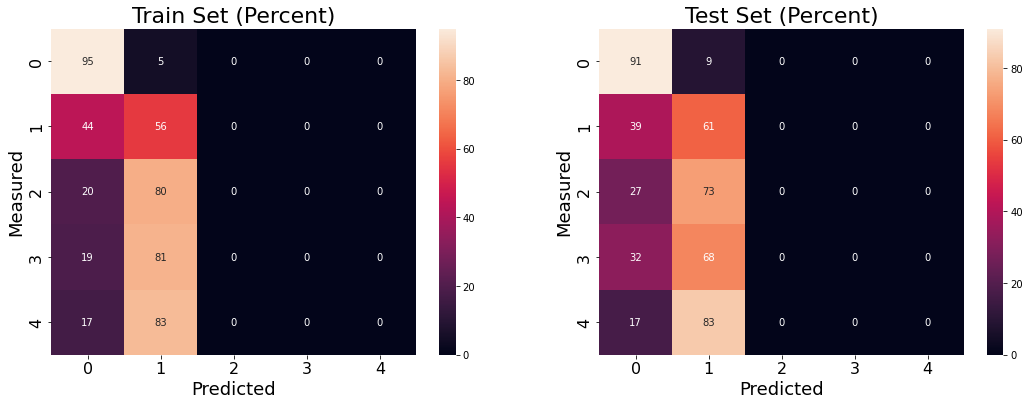

In [33]:
plot_confusion_matrix(dtc_scaled, X_train_scaled, X_test_Scaled, Y_train_scaled, Y_test_scaled)

Precision score for training set is :0.74
Precision score for testing  set is :0.72
Recall score for training set is :0.95
Recall score for testing  set is :0.91
F1 score for training set is :0.83
F1 score for testing  set is :0.81
AUC for training set is :0.85
AUC for testing  set is :0.77


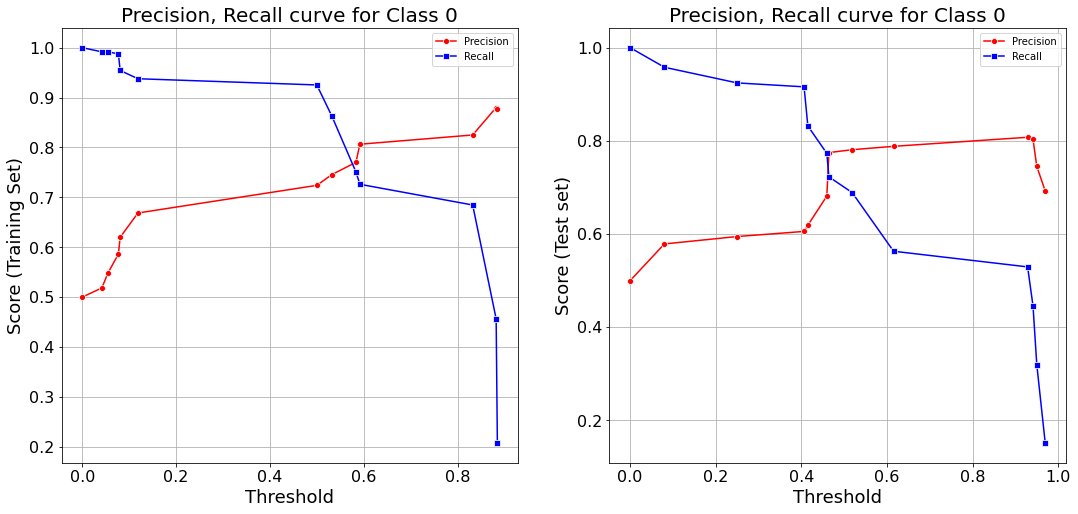

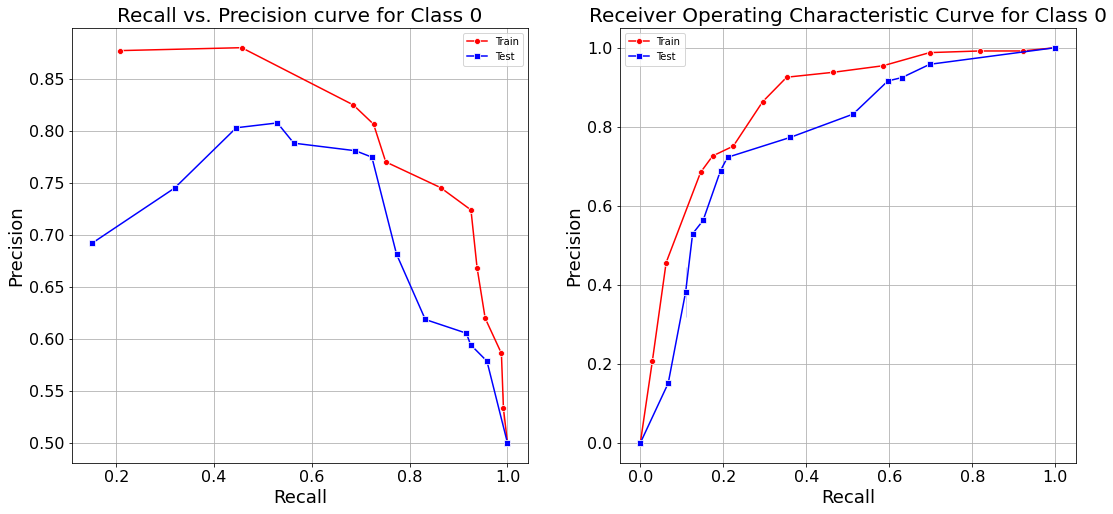

In [34]:
get_precision_recall(dtc_scaled, X_train_scaled, X_test_Scaled, Y_train_scaled, Y_test_scaled, 0)

Precision score for training set is :0.0
Precision score for testing  set is :0.0
Recall score for training set is :0.0
Recall score for testing  set is :0.0
F1 score for training set is :0.0
F1 score for testing  set is :0.0
AUC for training set is :0.65
AUC for testing  set is :0.52


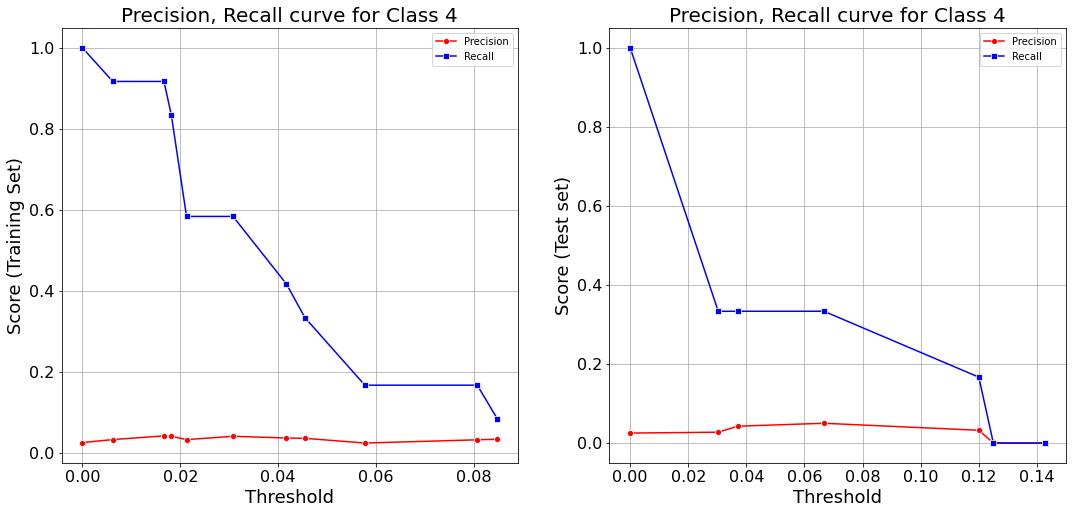

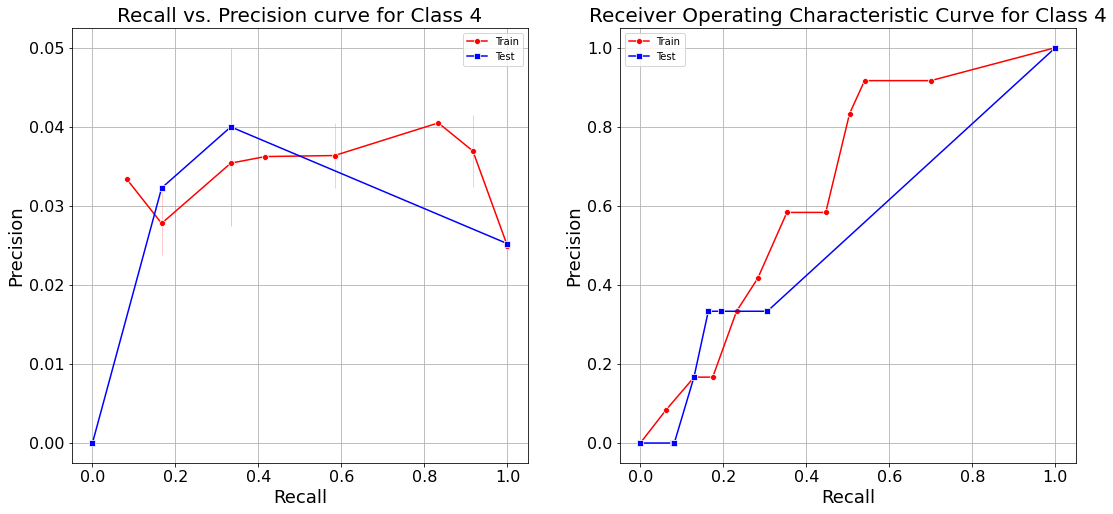

In [35]:
get_precision_recall(dtc_scaled, X_train_scaled, X_test_Scaled, Y_train_scaled, Y_test_scaled, 4)